# Beat Tracking

## Imports

In [295]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

from scipy.signal import medfilt as medfilt
from scipy.ndimage import maximum_filter1d as maxfilt

from sklearn.cluster import KMeans
from collections import Counter

import mir_eval

## Loading a file

First applying and demonstrating the pipeline for one file with visualization, towards the end will run for a set of files for a generalized evaluation

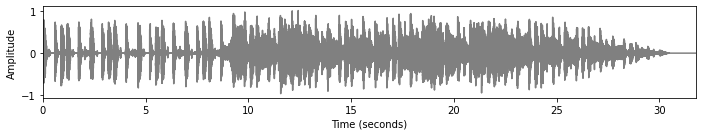

In [2]:
path_data = '../ballroom-data/'

# For now just testing with one
audio_file = path_data+'/Rumba-International/Media-105611.wav'

# Load audio
x, sr = librosa.load(os.path.join(audio_file))  # sampled at a rate of 22050 Hz
ipd.display(ipd.Audio(x,rate=sr))

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

## Onset Detection

[0.0,
 0.5804988662131519,
 0.8591383219954649,
 1.7414965986394557,
 2.8792743764172335,
 3.4597732426303858,
 4.040272108843538,
 4.62077097505669,
 5.201269841269841,
 5.479909297052155,
 5.758548752834467,
 6.339047619047619,
 6.9195464852607715,
 7.500045351473923,
 8.080544217687075,
 8.661043083900227,
 9.798820861678005,
 10.95981859410431,
 13.839092970521543,
 14.419591836734694,
 15.000090702947846,
 15.580589569160997,
 16.16108843537415,
 16.741587301587302,
 17.020226757369613,
 17.322086167800453,
 17.87936507936508,
 18.45986394557823,
 20.20136054421769,
 22.50013605442177,
 23.08063492063492,
 23.661133786848072,
 24.241632653061224,
 24.79891156462585,
 25.959909297052153]

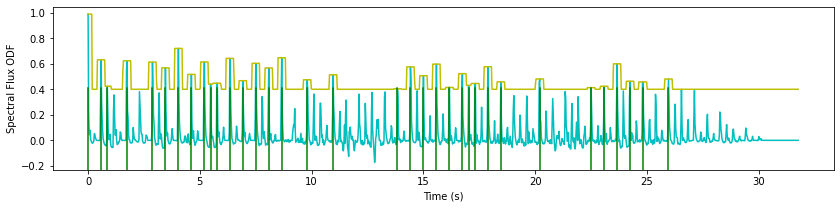

In [391]:
n = 2048
window = 'hann'
hop_length = 512

width = 15
threshold= 0.4

def detect_onsets(x, width, threshold, plot=False):
    # Short Fast Fourier Transform for spectrogram of audio
    D = np.abs(librosa.stft(x, n_fft=n, window=window, hop_length=hop_length))  # STFT
    D_transp = D.transpose()
    
    # Initialise variables for iterating
    frames = len(D_transp)
    odf = np.zeros(frames)  # stores odf spectral values for insinuating onsets
    bins = len(D)
    prev_magnitude = np.zeros(bins)  # stores magnitude of previous frame
    
    # Iterate through frames, process data via spectral flux
    for i, frame in enumerate(D_transp):
        magnitude = np.abs(frame)
        
        has_greater_magnitude = np.greater(magnitude, prev_magnitude)
        diff_magnitude = np.subtract(magnitude, prev_magnitude)
        
        spectral_flux = np.mean(np.multiply(has_greater_magnitude, diff_magnitude))
        odf[i] = spectral_flux
        
        prev_magnitude = magnitude
        
    # Normalise with respect to maximum odf value
    mx = max(odf)
    if mx > 0: odf /= mx
        
    # Computing peak times by filtering and thresholding
    hop_time = hop_length / sr
    t = np.arange(len(odf)) * hop_time
    odf_med = odf - medfilt(odf, width)
    odf_max = maxfilt(odf_med, width, mode='nearest', axis=0)
    
    thresholds = [max(i, threshold) for i in odf_max]
    peak_args = np.nonzero(np.greater_equal(odf_med, thresholds))
    peak_times = peak_args[0] * hop_time
    
    if plot:
        plt.figure(figsize=(14, 3))
        plt.xlabel('Time (s)')
        plt.ylabel('Spectral Flux ODF')
        plt.plot(t, odf_med, 'c')
        plt.plot(t, thresholds, 'y')
        for p in peak_times:
           plt.axvline(p, ymax=0.5, color='g')
    
    return peak_times
    
onsets = detect_onsets(x, width=width, threshold=threshold, plot=True)
list(onsets)

## IOI Clustering

[0.5805, 1.161, 1.7415, 2.8793, 4.0403, 5.178]

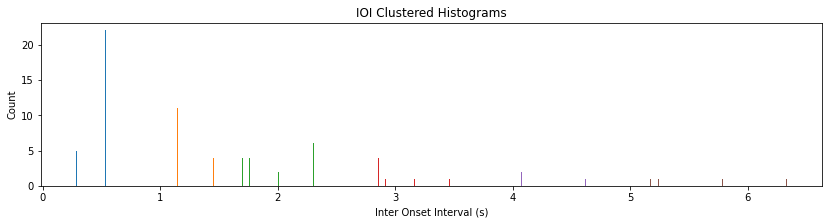

In [392]:
def ioi_clustering(onsets, n_clusters=6, plot=False):
    
    # Compute inter onset intervals of up to n_clusters apart
    ioi = []
    for i in range(1, n_clusters):
        for j in range(i, len(onsets), i):
            ioi.append(onsets[j] - onsets[j-i])

    temp = np.array(ioi).reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(temp)
    
    # Construct clusters array and sort for convinience
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(ioi[i])
    clusters = sorted(clusters)
    
    if plot:
        plt.figure(figsize=(14, 3))
        plt.title('IOI Clustered Histograms')
        plt.xlabel('Inter Onset Interval (s)')
        plt.ylabel('Count')
        plt.hist(clusters, 100)  
    
    # Find the mode of each cluster
    ioi_common = []
    for clust in clusters:
        dict_counter = Counter()
        for x  in clust:
            dict_counter[round(x, 4)] += 1
    
        ioi_common.append(dict_counter.most_common()[0][0])
        
    return clusters, ioi_common
    
ioi_clusters, ioi_common = ioi_clustering(onsets, plot=True)
ioi_common

## Periodicity function

In [393]:
# Compute tempos for each common IOI in terms of BPM
def ioi_to_tempo(ioi_common):
    return [60 / x for x in ioi_common]

# Compute ratios between common tempos
def tempo_ratio_matrix(tempo):
    ratios = []
    for i in range(len(tempo)):
        ratios.append([])
        for j in range(len(tempo)):
            ratios[i].append(tempo[i]/tempo[j])
            
    return ratios

tempo = ioi_to_tempo(ioi_common)
ratios = tempo_ratio_matrix(tempo)
print(np.array(tempo))
print()
print(np.array(ratios))

[103.35917313  51.67958656  34.45305771  20.83839822  14.8503824
  11.58748552]

[[1.         2.         3.         4.96003445 6.96003445 8.91989664]
 [0.5        1.         1.5        2.48001723 3.48001723 4.45994832]
 [0.33333333 0.66666667 1.         1.65334482 2.32001148 2.97329888]
 [0.2016115  0.40322301 0.60483451 1.         1.40322301 1.79835377]
 [0.14367745 0.2873549  0.43103235 0.7126451  1.         1.281588  ]
 [0.11210892 0.22421784 0.33632677 0.55606412 0.78028196 1.        ]]


## Prediction

In [390]:
 def agent_tracking(onsets, ioi_common):
    
    max_time = len(x) / sr
    agent_predictions = []  # A history of each of the agents paths
    
    # Number of agents proportionate to number of clusters common ioi
    # Loops through common iois, and starting points based on onsets
    for ioi in ioi_common:
        for i in range(len(ioi_common)):
            
            state = onsets[i] 
            while state < max_time:
                state += ioi  # jump by an ioi
                
                print(state)
                
                # Adjust the state to the closest neighbouring onset
                distances = np.array([abs(state - x) for x in onsets])
                closest = np.argmin(distances)
                state = onsets[closest]
                
                print(state)     
            
            
        
#     start = onsets[arg_start]
#     max_time = len(x) / sr
#     estimated_beats = []
#     new_beat = 0

#     while new_beat < max_time:
#         if len(estimated_beats) == 0:
#             estimated_beats.append(start)
#         else:
#             prev = estimated_beats[-1]
#             new_beat = prev + ioi_common
#             estimated_beats.append(round(new_beat,2))  # rounding to 2 d.p.
            
#     return np.array(estimated_beats[:-4])

print(onsets)
estimated_beats = agent_tracking(onsets, ioi_common)
estimated_beats

[2.32199546e-02 8.82358277e-01 1.25387755e+00 2.32199546e+00
 3.20435374e+00 3.48299320e+00 4.71365079e+00 5.50312925e+00
 5.78176871e+00 6.94276644e+00 7.80190476e+00 8.10376417e+00
 9.26476190e+00 1.04025397e+01 1.15635374e+01 1.38623129e+01
 1.47214512e+01 1.50233107e+01 1.61610884e+01 1.70434467e+01
 1.73453061e+01 2.19428571e+01 2.31038549e+01 2.54026304e+01]
0.6037199546485261
0.8823582766439909
1.462858276643991
1.253877551020408
1.8343775510204081
2.3219954648526078
2.902495464852608
3.2043537414965986
3.7848537414965984
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3.4829931972789114
4.063493197278912
3

KeyboardInterrupt: 

## Results

OrderedDict([('F-measure', 0.2558139534883721),
             ('Cemgil', 0.11037684163106727),
             ('Cemgil Best Metric Level', 0.11037684163106727),
             ('Goto', 0.0),
             ('P-score', 0.627906976744186),
             ('Correct Metric Level Continuous', 0.4186046511627907),
             ('Correct Metric Level Total', 0.4418604651162791),
             ('Any Metric Level Continuous', 0.4186046511627907),
             ('Any Metric Level Total', 0.4418604651162791),
             ('Information gain', 0.4037741145282114)])

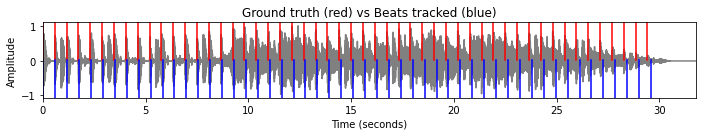

In [55]:
path_data = '../ballroom-annotations/'

# For now just testing with one
annotations_file = path_data+'Media-105611.beats'

def plot_play(true_beats, estimated_beats, x):
    # Audio player
    y = librosa.clicks(times=estimated_beats, sr=sr, length=len(x))
    ipd.display(ipd.Audio(x + y, rate=sr))

    # Plot audio
    t1 = np.arange(x.shape[0]) / sr
    plt.figure(figsize=(10, 2))
    plt.plot(t1, x, color='gray')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t1[0], t1[-1]])
    plt.title('Ground truth (red) vs Beats tracked (blue)')
    plt.tight_layout()

    for b in true_beats:
       plt.axvline(b, ymin=0.5, color='r')
    for b in estimated_beats:
       plt.axvline(b, ymax=0.5, color='b')  

    
beat_annotations = np.genfromtxt(annotations_file, delimiter=' ')
true_beats = beat_annotations.transpose()[0]
plot_play(true_beats, estimated_beats, x)
mir_eval.beat.evaluate(true_beats, np.array(estimated_beats))

## Generalizing to datasets

In [323]:
# TODO